In [1]:
import numpy as np
import cv2
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


# Drawing a number

When we run this cell we will be able to draw a shape.We are drawing a number (0,9).

In [15]:

drawing = False
showing = 1
new_image = np.zeros((500,500,3),np.float32)

def draw(event,x,y,flags,param):
    
    global showing,drawing,new_image
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
    
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.circle(img,center = (x,y), radius = 8 , color = (255,255,0), thickness = -1) # if thickness == 1 it fill up
            
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        
    elif event == cv2.EVENT_RBUTTONDOWN:
        new_image = img
        showing = 0
        
        return new_image
        
cv2.namedWindow(winname = "draw")
cv2.setMouseCallback("draw",draw)






img = np.zeros((500,500,3),np.float32)



while showing == 1: 
    cv2.imshow("draw",img)
    if cv2.waitKey(20) & 0xFF == 27:
        
        break
        
cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


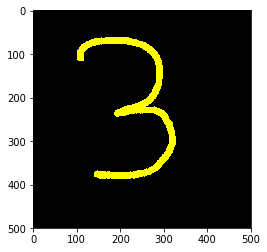

In [16]:
plt.imshow(new_image)
#The shape we have drawn

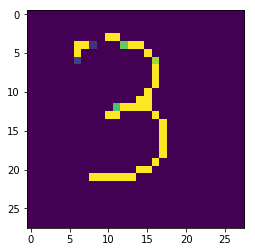

In [17]:
resized_img = cv2.resize(new_image,(28,28))
resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
plt.imshow(resized_img)
#we have resized the image because shape of our dataset(mnist) is 28x28. Then we have converted the color to gray from BGR(blue,green,red)

In [18]:
resized_img = torch.from_numpy(resized_img)

print(type(resized_img))
print(resized_img.shape)
#we have converted the type of image from numpy array to pytorch tensor

<class 'torch.Tensor'>
torch.Size([28, 28])


# Downloading and preparing dataset (mnist)

In [5]:


mean = 0.1307
std = 0.3081

transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((mean,),
                                                            (std,))])

trainset = datasets.MNIST("MNIST_data/", download = True , train = True ,transform = transform)
testset = datasets.MNIST("MNIST_data/", download = True , train = False ,transform = transform)



indices = list(range(len(trainset)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(trainset))) #0.2 validation size
train_idx, valid_idx = indices[split:], indices[:split]



train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


trainloader = torch.utils.data.DataLoader(trainset,batch_size = 64,sampler = train_sampler)
validloader = torch.utils.data.DataLoader(trainset,batch_size = 64,sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(testset,batch_size = 64, shuffle = True)

# Building The Neural Network Architecture

There are two diffrent types of neural network below. Inside of the comment block the model is that fully connected neural network.
The actual model is CNN (convolutional Neural Network). We should use CNN because it performs better than fully connected neural network on image dataset.

In [9]:
"""model = nn.Sequential(nn.Linear(784,128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                     nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.01)"""


""""

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        
        self.pool =nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(7*7*16,256)
        
        self.fc2 = nn.Linear(256,64)
        
        self.fc3 = nn.Linear(64,10)
        
        self.BN1 = nn.BatchNorm2d(8)
        
        self.BN2 = nn.BatchNorm2d(16)
        
    def forward(self,x):
        
        
        x = self.pool(F.relu(self.BN1(self.conv1(x))))
        
        x = self.pool(F.relu(self.BN2(self.conv2(x))))
 
        x = x.view(-1, 7 * 7 * 16)
    
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        
        return x"""


class CNN(nn.Module):
    
    def __init__(self):
            super(CNN,self).__init__()
            
            self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
            self.batch_norm1 = nn.BatchNorm2d(8) # feature map = 8
        
            self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
           
            self.batch_norm2 = nn.BatchNorm2d(32) #feature map = 32
            
            self.fc1 = nn.Linear(7*7*32,600)
            self.fc2 = nn.Linear(600,10)
            
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool2d(kernel_size = 2)

    def forward(self,x):
            out = self.cnn1(x)
            out = self.batch_norm1(out)
            out = self.relu(out)
            out = self.maxpool(out)
            out = self.cnn2(out)
            out = self.batch_norm2(out)
            out = self.relu(out)
            out = self.maxpool(out)
            # flattening:
            out = out.view(-1,1568)
            out = self.fc1(out)
            out = self.relu(out)
            out = self.fc2(out)
            return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model on the training set and choosing the best parameters by using the validation set

Again there are 2 different types of way to train the models. One of them is for fully connected neural network and the other one is for CNN.

In [10]:
""""epochs = 6

valid_loss_min = np.Inf

for e in range(epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()
    for images,labels in trainloader:
        
        images, labels = images.to(device), labels.to(device)

        
        
        
        log_ps = model(images)

        loss = criterion(log_ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    model.eval() 
    for images, labels in validloader:
        
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)

        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
        
    
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss"""

n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
       
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.450298 	Validation Loss: 0.090914
Validation loss decreased (inf --> 0.090914).  Saving model ...
Epoch: 2 	Training Loss: 0.070974 	Validation Loss: 0.095294
Epoch: 3 	Training Loss: 0.051506 	Validation Loss: 0.062060
Validation loss decreased (0.090914 --> 0.062060).  Saving model ...
Epoch: 4 	Training Loss: 0.043930 	Validation Loss: 0.051119
Validation loss decreased (0.062060 --> 0.051119).  Saving model ...
Epoch: 5 	Training Loss: 0.036472 	Validation Loss: 0.056859
Epoch: 6 	Training Loss: 0.034323 	Validation Loss: 0.062366
Epoch: 7 	Training Loss: 0.031190 	Validation Loss: 0.068888
Epoch: 8 	Training Loss: 0.027700 	Validation Loss: 0.059696
Epoch: 9 	Training Loss: 0.026937 	Validation Loss: 0.062949
Epoch: 10 	Training Loss: 0.026725 	Validation Loss: 0.089331


In [11]:
model.load_state_dict(torch.load('model.pt'))# saving the best model.

<All keys matched successfully>

# Defining the number in the picture we draw

In [19]:
model.eval()
with torch.no_grad():
    resized_img = resized_img.to(device)
    resized_img  = resized_img.view(1,1,28,28)
    print(resized_img.shape)
    
    output = model(resized_img)

    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    print(top_class)
    

torch.Size([1, 1, 28, 28])
tensor([[3]], device='cuda:0')
